In [17]:
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# Load the dataset
dataset_path = 'city_day.csv'  # Adjust this path to your environment
data = pd.read_csv(dataset_path)

# Select the relevant columns for prediction
columnsx = ['PM2.5', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3']

# Step 1: Check for missing values in predictor features
print("Missing values in predictor features before imputation:")
print(data[columnsx].isnull().sum())

# Step 2: Fill missing predictor feature values using KNN Imputation
imputer = KNNImputer(n_neighbors=5)  # Initialize KNN Imputer
data[columnsx] = imputer.fit_transform(data[columnsx])  # Impute missing values in predictors

# Step 3: Re-check for missing values in predictor features
print("Missing values in predictor features after KNN Imputation:")
print(data[columnsx].isnull().sum())  # This should show 0 missing values in these columns

# Step 4: Load the pre-trained model (Random Forest, Gradient Boosting, etc.)
model_filename = 'aqi_rf_model_2.pkl'  # Change this to the actual path of your saved model
loaded_model = pickle.load(open(model_filename, 'rb'))

# Initialize the scaler (assuming data was scaled before training)
scaler = StandardScaler()

# Fit the scaler on the existing data (non-missing AQI rows)
X_train = data[data['AQI'].notna()][columnsx]  # Use rows where AQI is not null to fit the scaler
scaler.fit(X_train)

# Step 5: Find the rows with missing AQI
X_missing = data[data['AQI'].isnull()][columnsx]

# Step 6: Scale the missing rows for prediction (use only relevant features)
X_missing_scaled = scaler.transform(X_missing)

# Step 7: Predict the missing AQI values using the loaded model
predicted_aqi = loaded_model.predict(X_missing_scaled)

# Step 8: Fill in the missing AQI values in the dataset
data.loc[data['AQI'].isnull(), 'AQI'] = predicted_aqi

# Step 9: Save the updated dataset as 'thefinaldataset.csv'
final_dataset_path = 'thefinaldataset.csv'  # Specify where to save the updated dataset
data.to_csv(final_dataset_path, index=False)

print("Missing AQI values have been predicted and the dataset is saved as 'thefinaldataset.csv'.")

# Step 10: Check if there are still missing values in AQI
print("Missing values in AQI after prediction:")
print(data['AQI'].isnull().sum())  # This should print 0 if all missing AQI values were filled


Missing values in predictor features before imputation:
PM2.5    4598
NO       3582
NO2      3585
NOx      4185
CO       2059
SO2      3854
O3       4022
dtype: int64
Missing values in predictor features after KNN Imputation:
PM2.5    0
NO       0
NO2      0
NOx      0
CO       0
SO2      0
O3       0
dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Missing AQI values have been predicted and the dataset is saved as 'thefinaldataset.csv'.
Missing values in AQI after prediction:
0


In [35]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler ,PowerTransformer
from sklearn.linear_model  import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold,train_test_split
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score,precision_score,recall_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pickle


In [22]:
data.isnull().sum()

,0
City,0
Date,0
PM2.5,0
PM10,11140
NO,0
NO2,0
NOx,0
NH3,10328
CO,0
SO2,0


In [24]:
data

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,01-01-2015,23.178,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,157.60,NaN
1,Ahmedabad,02-01-2015,27.004,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,77.76,NaN
2,Ahmedabad,03-01-2015,124.010,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,240.07,NaN
3,Ahmedabad,04-01-2015,40.012,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,94.91,NaN
4,Ahmedabad,05-01-2015,142.728,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,370.72,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29526,Visakhapatnam,27-06-2020,15.020,50.94,7.68,25.06,19.54,12.47,0.47,8.55,23.30,2.24,12.07,0.73,41.00,Good
29527,Visakhapatnam,28-06-2020,24.380,74.09,3.42,26.06,16.53,11.99,0.52,12.72,30.14,0.74,2.21,0.38,70.00,Satisfactory
29528,Visakhapatnam,29-06-2020,22.910,65.73,3.45,29.53,18.33,10.71,0.48,8.42,30.96,0.01,0.01,0.00,68.00,Satisfactory
29529,Visakhapatnam,30-06-2020,16.640,49.97,4.05,29.26,18.80,10.03,0.52,9.84,28.30,0.00,0.00,0.00,54.00,Satisfactory


In [25]:
data.dtypes

,0
City,object
Date,object
PM2.5,float64
PM10,float64
NO,float64
NO2,float64
NOx,float64
NH3,float64
CO,float64
SO2,float64


In [26]:
data.describe(include='all')

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
count,29531,29531,29531.000000,18391.000000,29531.000000,29531.000000,29531.000000,19203.000000,29531.000000,29531.000000,29531.000000,23908.000000,21490.000000,11422.000000,29531.000000,24850
unique,26,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
top,Ahmedabad,01-07-2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Moderate
freq,2009,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8829
mean,NaN,NaN,66.882577,118.127103,17.361203,28.270265,36.683234,23.483476,2.227784,14.438253,33.410643,3.280840,8.700972,3.070128,159.717044,NaN
std,NaN,NaN,61.463829,90.605110,21.607977,23.394320,35.444553,25.684275,6.720207,17.489888,20.767439,15.811136,19.969164,6.323247,131.748518,NaN
min,NaN,NaN,0.040000,0.010000,0.020000,0.010000,0.000000,0.010000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,13.000000,NaN
25%,NaN,NaN,31.780000,56.255000,6.150000,11.925000,14.340000,8.580000,0.530000,5.850000,18.360000,0.120000,0.600000,0.140000,85.275000,NaN
50%,NaN,NaN,51.126000,95.680000,10.480000,22.740000,27.100000,15.850000,0.940000,9.480000,30.850000,1.070000,2.970000,0.980000,118.220000,NaN
75%,NaN,NaN,75.420000,149.745000,18.800000,36.665000,45.920000,30.020000,1.620000,14.545000,43.175000,3.080000,9.150000,3.350000,185.000000,NaN


In [27]:
null_percentage=data.isnull().mean() * 100
null_percentage

,0
City,0.000000
Date,0.000000
PM2.5,0.000000
PM10,37.723071
NO,0.000000
NO2,0.000000
NOx,0.000000
NH3,34.973418
CO,0.000000
SO2,0.000000


In [28]:
columns_to_drop = null_percentage[null_percentage > 16.0].index

# Drop those columns from the DataFrame
data1 = data.drop(columns=columns_to_drop)


In [29]:
data1.isnull().sum()

,0
City,0
Date,0
PM2.5,0
NO,0
NO2,0
NOx,0
CO,0
SO2,0
O3,0
AQI,0


In [30]:
columns_to_drop

Index(['PM10', 'NH3', 'Benzene', 'Toluene', 'Xylene'], dtype='object')

In [31]:
data2 = data1.drop(columns='AQI_Bucket')
data2.isnull().sum()

,0
City,0
Date,0
PM2.5,0
NO,0
NO2,0
NOx,0
CO,0
SO2,0
O3,0
AQI,0


In [32]:
data2.columns
data2=data2.drop(columns=['City','Date'])

In [33]:
data2.isnull().sum()

,0
PM2.5,0
NO,0
NO2,0
NOx,0
CO,0
SO2,0
O3,0
AQI,0


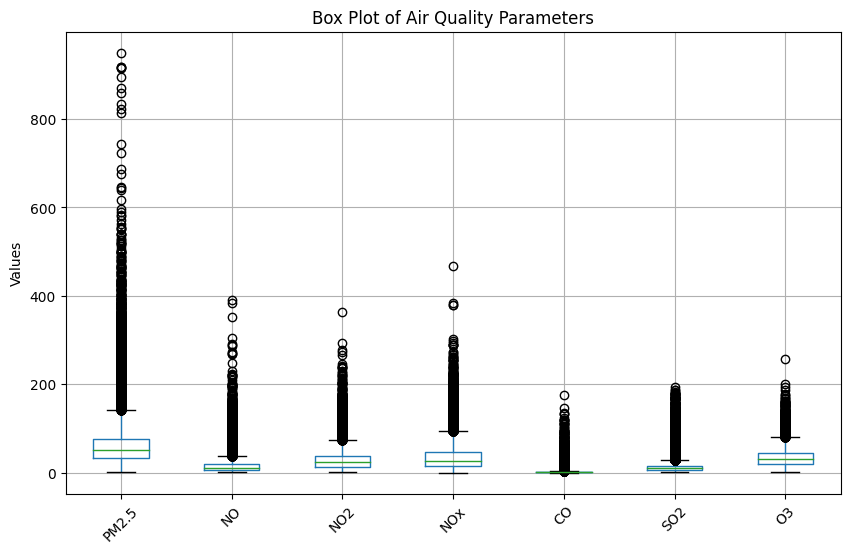

In [36]:
columns_to_plot = ['PM2.5', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3']

plt.figure(figsize=(10, 6))
data2[columns_to_plot].boxplot()


plt.title('Box Plot of Air Quality Parameters')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.ylabel('Values')

# Show the plot
plt.show()

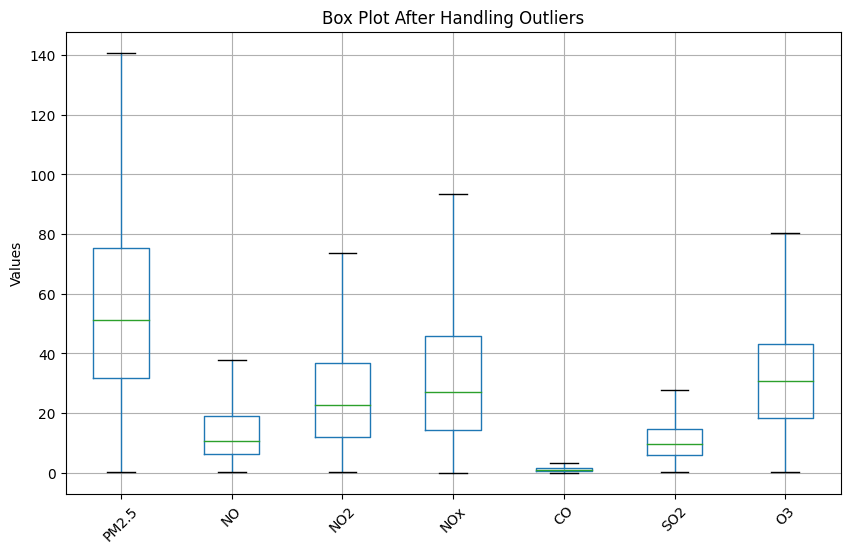

In [37]:
def cap_outliers_iqr(data2, columns):
    for col in columns:
        Q1 = data2[col].quantile(0.25)
        Q3 = data2[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Cap the values
        data2[col] = np.where(data2[col] < lower_bound, lower_bound,
                              np.where(data2[col] > upper_bound, upper_bound, data2[col]))
    return data2

# Cap outliers for the selected columns
data3 = cap_outliers_iqr(data2, columns_to_plot)

# Visualize after capping outliers
plt.figure(figsize=(10, 6))
data3[columns_to_plot].boxplot()
plt.title('Box Plot After Handling Outliers')
plt.xticks(rotation=45)
plt.ylabel('Values')
plt.show()


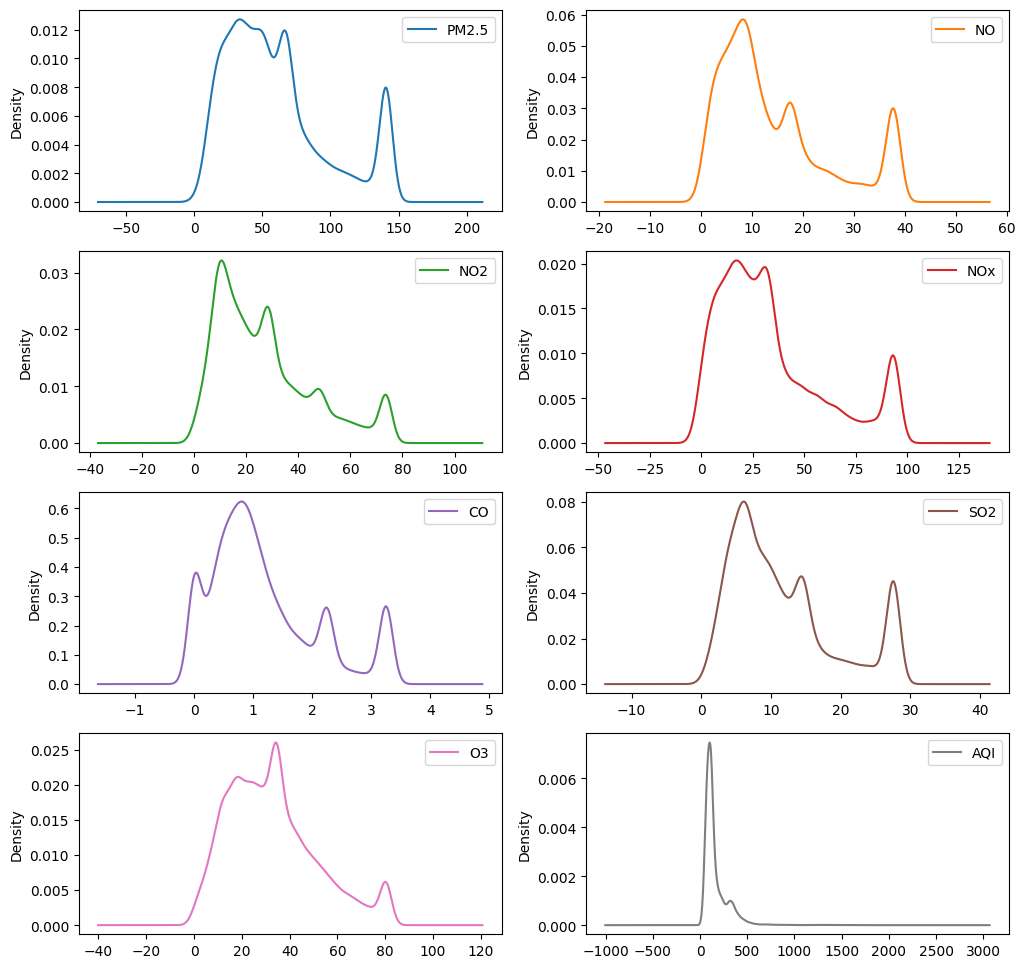

In [38]:
data3.plot(kind='density',subplots=True,layout=(4,2),figsize=(12,12),sharex=False)
plt.show()

In [39]:
data3_copy = data3.copy()

# Initialize the StandardScaler
scaler = StandardScaler()

# Specify the columns to scale
columns_to_scale = ['PM2.5', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3']

# Fit the scaler on the specified columns and transform them in the copy
data3_copy[columns_to_scale] = scaler.fit_transform(data3_copy[columns_to_scale])

# Create the new DataFrame (data4) with the unchanged and scaled columns
data4 = data3_copy[ columns_to_scale + ['AQI']]

In [40]:
# Create a copy of data5 to avoid affecting the original DataFrame
data4_copy = data4.copy()

# Initialize the PowerTransformer with Yeo-Johnson method
transformer = PowerTransformer(method='yeo-johnson')

# Specify the columns to transform
columns_to_transform = ['PM2.5', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3']

# Fit the transformer on the specified columns and transform them in the copy
data4_copy[columns_to_transform] = transformer.fit_transform(data4_copy[columns_to_transform])

# Create the new DataFrame (data6) with the unchanged and transformed columns
data5 = data4_copy[columns_to_transform + ['AQI']]


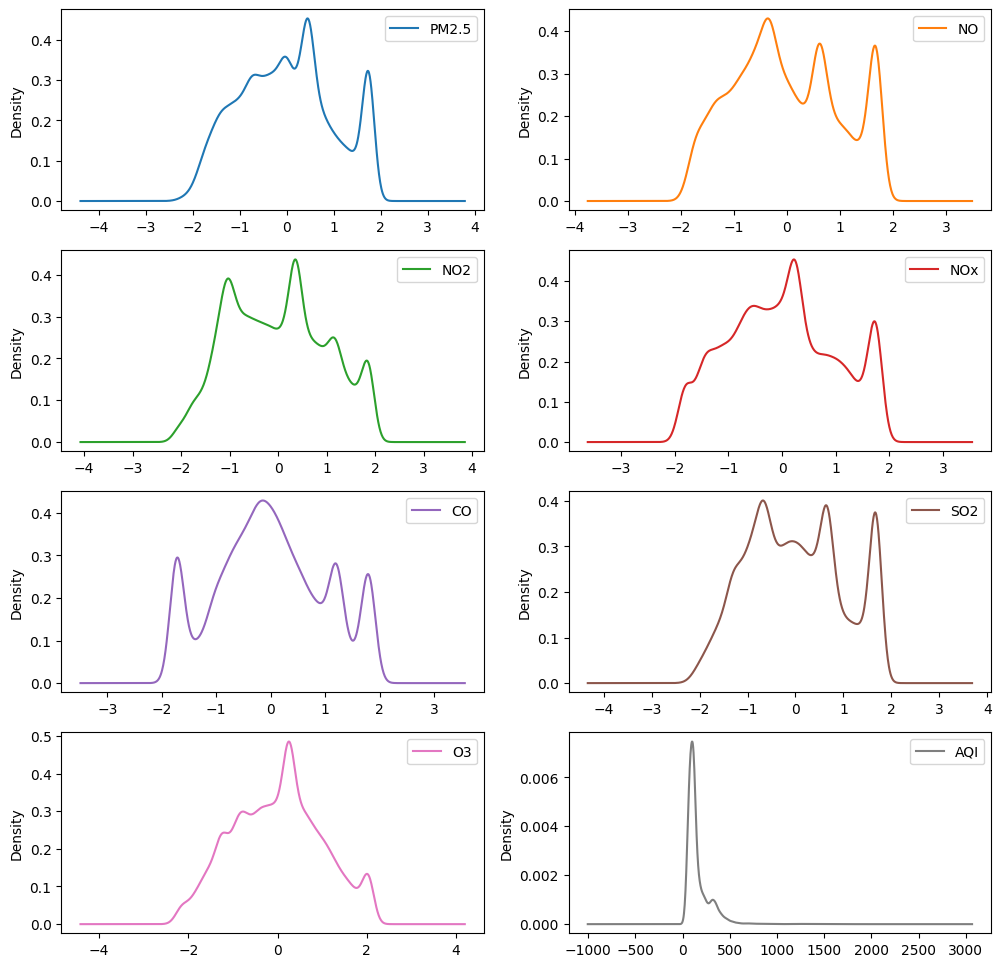

In [41]:
data5.plot(kind='density',subplots=True,layout=(4,2),figsize=(12,12),sharex=False)
plt.show()

In [42]:
columnsx = ['PM2.5', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'O3']
X=data5[columnsx]
y=data5['AQI']

# Initialize the models
rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)
lr_model = LinearRegression()

# Initialize K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to evaluate model using K-Fold Cross Validation
def evaluate_model(model, X, y):
    mse_list = []
    r2_list = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        predictions = model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)

        mse_list.append(mse)
        r2_list.append(r2)

    return sum(mse_list) / len(mse_list), sum(r2_list) / len(r2_list)

# Evaluate each model using K-Fold Cross Validation
rf_cv_mse, rf_cv_r2 = evaluate_model(rf_model, X, y)
gb_cv_mse, gb_cv_r2 = evaluate_model(gb_model, X, y)
lr_cv_mse, lr_cv_r2 = evaluate_model(lr_model, X, y)



In [43]:
# Print the K-Fold Cross Validation results
print("Random Forest     - K-Fold CV Root Mean Squared Error:", rf_cv_mse**0.5)
print("Random Forest     - K-Fold CV R^2 Score:", rf_cv_r2)

print("\nGradient Boosting - K-Fold CV Root Mean Squared Error:", gb_cv_mse**0.5)
print("Gradient Boosting - K-Fold CV R^2 Score:", gb_cv_r2)

print("\nLinear Regression - K-Fold CV Root Mean Squared Error:", lr_cv_mse**0.5)
print("Linear Regression - K-Fold CV R^2 Score:", lr_cv_r2)

Random Forest     - K-Fold CV Root Mean Squared Error: 52.30794945210795
Random Forest     - K-Fold CV R^2 Score: 0.8426273946467078

Gradient Boosting - K-Fold CV Root Mean Squared Error: 55.7364268667988
Gradient Boosting - K-Fold CV R^2 Score: 0.8214005157593158

Linear Regression - K-Fold CV Root Mean Squared Error: 94.32028733431099
Linear Regression - K-Fold CV R^2 Score: 0.4884066823728994


In [44]:
# saving the model to the local file system
filename = 'aqi_rf_model_final.pkl'
pickle.dump(rf_model, open(filename, 'wb'))

In [46]:
with open('scaler_final.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

In [47]:
# prediction using the saved model
loaded_model = pickle.load(open(filename, 'rb'))
a=loaded_model.predict(scaler.transform([[65.04,14.19,30.1,44.21,14.19,65.91,31.88]]))
a

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([270.8646])

In [48]:
#prediction using the saved model
loaded_model = pickle.load(open(filename, 'rb'))
B=loaded_model.predict(scaler.transform([[43.55, 48.46, 18.45, 50.12, 0.72, 10.26, 42.7]]))
B

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([113.1607])